In [3]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import LSE_net
import importlib
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
from pathlib import Path
import GD
from Anneal import anneal

In [5]:
seed=0;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)

Running on:  cpu


### Initialize an FLPO scenario

Run the below command if you encounter errors running the plotting block.

In [6]:
# !pip install nbformat --upgrade

num_drones = 100	num_facilities = 20	dim = 2
Data Created.


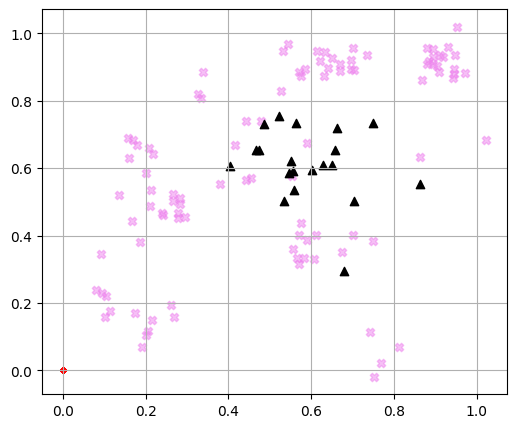

In [7]:
# UAV FLPO MetaData
num_drones = 100
n_drone_clusters = 20
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 20
dim_ = 2
print(f"num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}")

START_locs, F_base, END_locs = generate_dataset(
    num_drones, n_drone_clusters, drone_cluster_split, num_facilities, dim_, device, drone_cluster_std_range=[0.02, 0.08], F_noise_std=0.1,
)
np_flpo_filename = 'numpy_FLPO_data/numpy_FLPO_data'
torchFLPO_2_numpyFLPO(START_locs, END_locs, F_base, np_flpo_filename, scale=1.0)

plot_UAV_FLPO(START_locs, END_locs, F_base)
plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

### Load the VRP net module

In [8]:
torch.cuda.empty_cache()
model_classes = {"VRPNet_L": VRPNet_L}
weights_address = (
    Path("Saved_models") /
    "VRPNet_L_lr1e-04_bs32_ep60000_samples1920000_cities50_inputdim2_"
    "workers0_hidden64_enc1_dec1_heads8_dropout0.30_"
    "train_PO_2025_05_17_22_43_32last_model.pth"
)
vrp_net = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in vrp_net.parameters():
    param.requires_grad = False
print("VRP NET loaded on: ", vrp_net.device)
print(summary(vrp_net))

Model created.
VRP NET loaded on:  cpu
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,048
│    └─ModuleList: 2-1                                                 --
│    │    └─MultiheadAttention: 3-1                                    (66,048)
│    │    └─MultiheadAttention: 3-2                                    (66,048)
│    │    └─MultiheadAttention: 3-3                                    (66,048)
│    │    └─MultiheadAttention: 3-4                                    (66,048)
│    │    └─MultiheadAttention: 3-5                                    (66,048)
│    │    └─MultiheadAttention: 3-6                                    (66,048)
│    └─ModuleList: 2-2                                                 --
│    │    └─MultiheadAttention: 3-7                                    (66,048)
│    │    └─MultiheadAt

### Load the LSE net module

In [9]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_19__15_47_58.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
D_max_range = lse_data['D_max_range']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'D_max_scale: {D_max_range}\nn_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

D_max_scale: 5.0
n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


### Test Model Passes and Gradients: 
The below blocks show that the value of the $\frac{\partial F_\beta}{\partial Y}$ at different $\beta$ values are linearly dependent. Further, since the $\frac{\partial F_\beta}{\partial Y}$ tends to $\frac{\partial d_{\min}}{\partial Y}$ as $\beta \rightarrow \infty$. Therefore, the optimal value of $Y$ at any $\beta$ is only influenced by the shortest path.

In [10]:
import ModelPass as MP

dmin_drones, grad_dmins, _ = MP.VRPNet_pass(vrp_net, F_base, START_locs, END_locs, method="Greedy", returnGrad=False)
print(f'dmins_drones: {dmin_drones.shape}')
# print(f'grad_dmins: {grad_dmins.shape}')
beta_min = 1e-3


dmins_drones: torch.Size([100, 1])


$\beta = 10^{-3}$

In [11]:

beta = 1e-3
freeEnergy0, dFreeEnergy0 = MP.LSENet_pass(lse_net, dmin_drones, D_max_range, beta, beta_min, returnGrad=False)
print(f'freeEnergy0: {freeEnergy0.shape}')
# print(f'dFreeEnergy0: {dFreeEnergy0.shape}')

total_free_energy = torch.mean(freeEnergy0)
total_gradient = torch.autograd.grad(
            outputs=total_free_energy,
            inputs=F_base,
            grad_outputs=torch.ones_like(total_free_energy),
            create_graph=True,
        )
G = total_gradient[0].squeeze(0)
# print(f'G:{G}')

freeEnergy0: torch.Size([100, 1])


$\beta = 1$

In [12]:
beta1 = 1
freeEnergy1, dFreeEnergy1 = MP.LSENet_pass(lse_net, dmin_drones, D_max_range, beta1, beta_min, returnGrad=False)
print(f'freeEnergy1: {freeEnergy1.shape}')
# print(f'dFreeEnergy1: {dFreeEnergy1.shape}')

total_free_energy1 = torch.mean(freeEnergy1)
total_gradient1 = torch.autograd.grad(
            outputs=total_free_energy1,
            inputs=F_base,
            grad_outputs=torch.ones_like(total_free_energy1),
            create_graph=True,
        )
G1 = total_gradient1[0].squeeze(0)
# print(f'G1:{G1}')

freeEnergy1: torch.Size([100, 1])


In [13]:
beta2 = 100
freeEnergy2, dFreeEnergy2 = MP.LSENet_pass(lse_net, dmin_drones, D_max_range, beta2, beta_min, returnGrad=False)
print(f'freeEnergy2: {freeEnergy2.shape}')
# print(f'dFreeEnergy1: {dFreeEnergy1.shape}')

total_free_energy2 = torch.mean(freeEnergy2)
total_gradient2 = torch.autograd.grad(
            outputs=total_free_energy2,
            inputs=F_base,
            grad_outputs=torch.ones_like(total_free_energy2),
            create_graph=True,
        )
G2 = total_gradient2[0].squeeze(0)
# print(f'G2:{G2}')

freeEnergy2: torch.Size([100, 1])


Component wise ratios of gradients at different $\beta$ values.

In [14]:
v = G[:,1]/G[:,0]
v1 = G1[:,1]/G1[:,0]
v2 = G2[:,1]/G2[:,0]

In [49]:
v/v1

tensor([0.9665, 1.0342, 0.9287, 1.0005, 0.4504], grad_fn=<DivBackward0>)

In [50]:
v1/v2

tensor([1.0112, 0.9891, 1.0085, 1.0002, 1.7642], grad_fn=<DivBackward0>)

In [51]:
v2/v

tensor([1.0232, 0.9776, 1.0676, 0.9994, 1.2584], grad_fn=<DivBackward0>)

### Create and a dataset for creating an original FLPO framework

In [77]:
node_locations = START_locs.to(torch.float64).numpy().squeeze()
destination_location = END_locs[0].to(torch.float64).numpy()
facility_location = F_base.to(torch.float64).detach().numpy().squeeze()

In [78]:
numpyFLPOdata = {}
numpyFLPOdata['nodeLocations'] = node_locations
numpyFLPOdata['destinationLocation'] = destination_location
numpyFLPOdata['facilityLocations'] = facility_location
numpyFLPOdata['numFacilities'] = facility_location.shape[0]
numpyFLPOdata['numNodes'] = node_locations.shape[0]
numpyFLPOdata['scale'] = 1.0

In [79]:
import pickle
filename = 'flpo_single_drone_data.pkl'
with open(filename, 'wb') as file:
    pickle.dump(numpyFLPOdata, file)

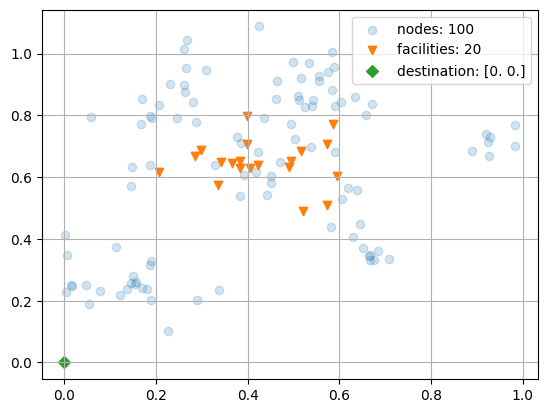

In [80]:
import classFLPO as cf
flpo = cf.FLPO(filename, plotFLPO=True, disType='sqeuclidean', selfHop=True)

In [81]:
Y0 = flpo.facilityLocations
Y0

array([[0.40460867, 0.62824064],
       [0.29846847, 0.68827707],
       [0.36543858, 0.6458351 ],
       [0.39949739, 0.79882133],
       [0.51712787, 0.68477511],
       [0.59590387, 0.60306102],
       [0.42316428, 0.64017123],
       [0.57250375, 0.70820016],
       [0.58558935, 0.77124304],
       [0.49442881, 0.65381062],
       [0.57260615, 0.5107305 ],
       [0.34131122, 0.65079188],
       [0.48961753, 0.63239694],
       [0.33649826, 0.57346737],
       [0.20648904, 0.615659  ],
       [0.521855  , 0.49156231],
       [0.39862821, 0.70617789],
       [0.2848199 , 0.6676175 ],
       [0.38452306, 0.62931937],
       [0.38374481, 0.65269083]])

In [82]:
init_guess = Y0.flatten()
init_guess

array([0.40460867, 0.62824064, 0.29846847, 0.68827707, 0.36543858,
       0.6458351 , 0.39949739, 0.79882133, 0.51712787, 0.68477511,
       0.59590387, 0.60306102, 0.42316428, 0.64017123, 0.57250375,
       0.70820016, 0.58558935, 0.77124304, 0.49442881, 0.65381062,
       0.57260615, 0.5107305 , 0.34131122, 0.65079188, 0.48961753,
       0.63239694, 0.33649826, 0.57346737, 0.20648904, 0.615659  ,
       0.521855  , 0.49156231, 0.39862821, 0.70617789, 0.2848199 ,
       0.6676175 , 0.38452306, 0.62931937, 0.38374481, 0.65269083])

In [83]:
flpo.bounds

[(0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0)]

In [88]:
cost, params, time = flpo.optimize_D(init_guess, beta=1e3, method='trust-constr', method_options={'verbose':1})

`gtol` termination condition is satisfied.
Number of iterations: 105, function evaluations: 4100, CG iterations: 580, optimality: 6.16e-09, constraint violation: 0.00e+00, execution time:  3.2 s.


In [89]:
cost

0.058904683169318774

In [90]:
flpo.facilityLocations = params.reshape(-1,2)

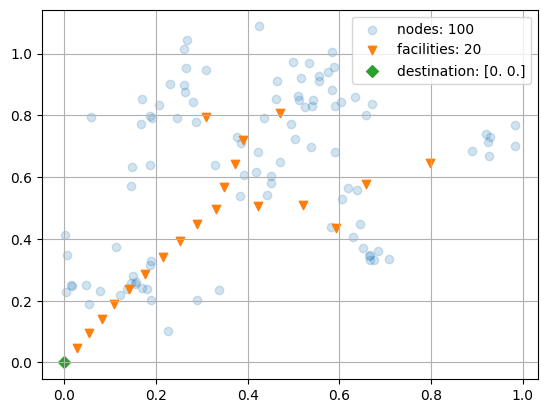

In [91]:
flpo.plotFLPO()